In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [94]:
# ============================
# 1. Load Preprocessed Dataset
# ============================

df = pd.read_csv("../data/preprocessed_data.csv")
print("\n✅ Dataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist(), "\n")

# Target column
target = "Perfect_Waste_Decomposition_System"

# Split features & labels
X = df.drop(columns=[target])
y = df[target]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("🔹 Training set shape:", X_train.shape)
print("🔹 Testing set shape:", X_test.shape, "\n")


✅ Dataset loaded successfully!
Shape: (2000, 19)
Columns: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'Perfect_Waste_Decomposition_System'] 

🔹 Training set shape: (1400, 18)
🔹 Testing set shape: (600, 18) 



In [95]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PC1                                 2000 non-null   float64
 1   PC2                                 2000 non-null   float64
 2   PC3                                 2000 non-null   float64
 3   PC4                                 2000 non-null   float64
 4   PC5                                 2000 non-null   float64
 5   PC6                                 2000 non-null   float64
 6   PC7                                 2000 non-null   float64
 7   PC8                                 2000 non-null   float64
 8   PC9                                 2000 non-null   float64
 9   PC10                                2000 non-null   float64
 10  PC11                                2000 non-null   float64
 11  PC12                                2000 no

In [96]:
# ============================
# 2. Define Models
# ============================

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
}





🚀 Training Logistic Regression...

📊 Results for Logistic Regression:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       300
         1.0       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



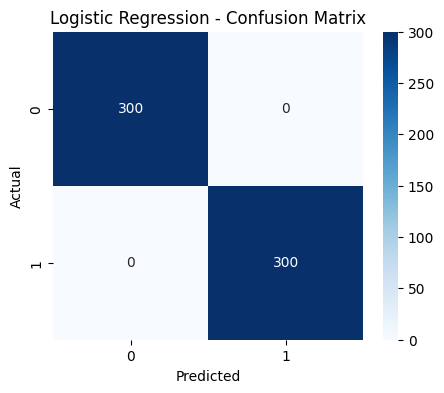

✅ Logistic Regression model saved to ../model/

🚀 Training Random Forest...

📊 Results for Random Forest:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       300
         1.0       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



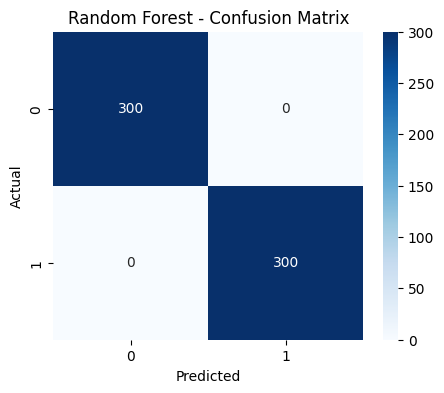

✅ Random Forest model saved to ../model/

🚀 Training SVM...

📊 Results for SVM:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       300
         1.0       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



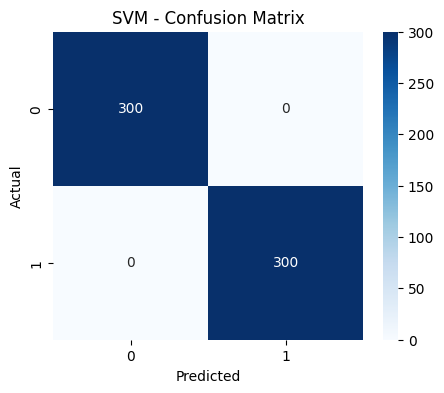

✅ SVM model saved to ../model/


In [97]:
# ============================
# 3. Train & Evaluate
# ============================

results = {}

for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n📊 Results for {name}:")
    print(classification_report(y_test, y_pred))

    # Save metrics
    results[name] = classification_report(y_test, y_pred, output_dict=True)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save trained model
    joblib.dump(model, f"../model/{name.replace(' ', '_').lower()}.pkl")
    print(f"✅ {name} model saved to ../model/")

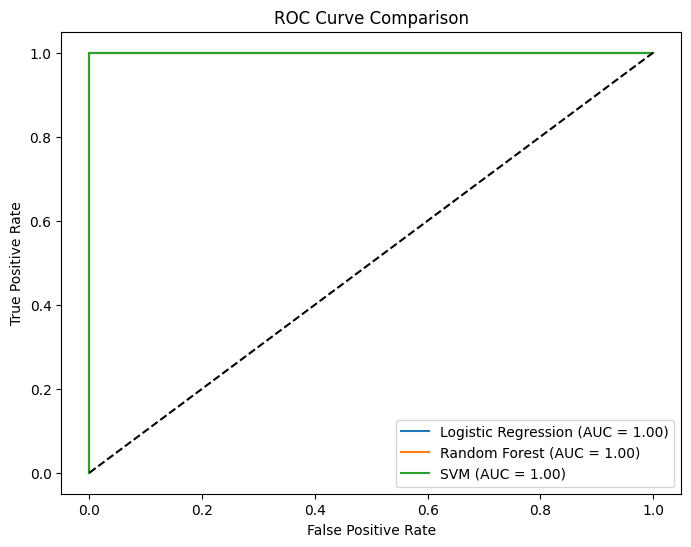

In [98]:
# ============================
# 4. ROC Curves Comparison
# ============================

plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()